# Congressional Analysis

This notebook focuses on the analysis of congressional vote prediction:

1. **Bill Passage Rate by Congress** - Institutional effectiveness trends
2. **Policy Areas Over Time** - Domain evolution patterns  
3. **Ideological Distribution (NOMINATE)** - Member positioning
4. **Party Cohesion Over Time** - Polarization trends

These visualizations provide critical context for prediction modeling.


In [1]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('default')
sns.set_palette("husl")

# Add src path
import sys
sys.path.append("../..")

from src.data_loaders.rollcall import (
    get_cleaned_rollcall_data, 
    get_raw_individual_votes,
    get_rollcall_data_crs_policy_areas,
    get_individual_votes_with_party
)

print("Libraries loaded successfully.")


Libraries loaded successfully.


In [2]:
# Load essential datasets
print("Loading data for analysis...")

# Individual votes
df_votes = pd.read_parquet('../data/house_senate_votes.parquet')
print(f"Individual votes: {df_votes.shape[0]:,} records")

# Member information  
df_members = pd.read_csv('../data/house_senate_members.csv')
print(f"Members: {df_members['icpsr'].nunique():,} unique individuals")

# Rollcall data
df_rollcall = get_cleaned_rollcall_data()
print(f"Bills: {df_rollcall.shape[0]:,} records")

# Policy data
df_policy = get_rollcall_data_crs_policy_areas()
policy_cols = [col for col in df_policy.columns if col.startswith('crs_policy_area_')]
print(f"Policy areas tracked: {len(policy_cols)}")

print(f"\nTime span: Congress {df_votes['congress'].min()} - {df_votes['congress'].max()}")
print("Data loading complete.")


Loading data for analysis...
Individual votes: 26,122,580 records
Members: 12,667 unique individuals
Loading cached data from /Users/choih/Documents/Summer 2025/stat5241_team_7/src/data/rollcall_cleaned_11.parquet
Bills: 11,324 records
Loading cached data from /Users/choih/Documents/Summer 2025/stat5241_team_7/src/data/rollcall_crs_policy_11.parquet
Policy areas tracked: 32

Time span: Congress 1 - 119
Data loading complete.


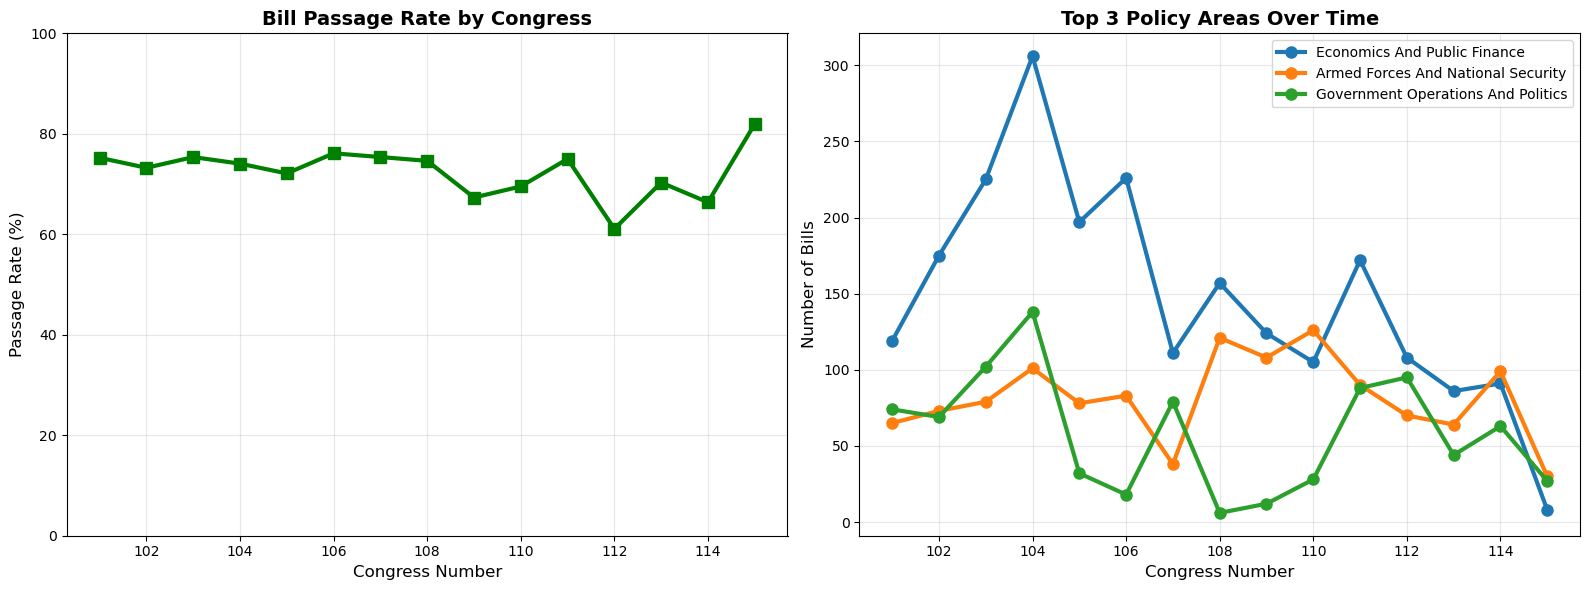

Average passage rate across all congresses: 72.5%
Most active policy area: Economics And Public Finance


In [ ]:
# VISUALIZATION 1 & 2: Bill Passage Rate + Policy Areas Over Time
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Bill Passage Rate by Congress
rollcall_by_congress = df_rollcall.reset_index().groupby('congress').agg({
    'vote_passed': ['count', 'sum']
})
rollcall_by_congress.columns = ['total_bills', 'passed_bills']
rollcall_by_congress['passage_rate'] = rollcall_by_congress['passed_bills'] / rollcall_by_congress['total_bills']

axes[0].plot(rollcall_by_congress.index, rollcall_by_congress['passage_rate'] * 100, 
             marker='s', color='green', linewidth=3, markersize=8)
axes[0].set_title('Bill Passage Rate by Congress', fontsize=14, weight='bold')
axes[0].set_xlabel('Congress Number', fontsize=12)
axes[0].set_ylabel('Passage Rate (%)', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(0, 100)

# 2. Policy Areas Over Time (Top 3)
policy_totals = df_policy[policy_cols].sum().sort_values(ascending=False)
rollcall_reset = df_rollcall.reset_index()
policy_time = df_policy.reset_index().merge(
    rollcall_reset[['congress', 'bill_number', 'rollnumber']], 
    on=['congress', 'bill_number', 'rollnumber'], how='left'
)

top_3_policies = policy_totals.head(3).index
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
for i, policy in enumerate(top_3_policies):
    policy_by_congress = policy_time.groupby('congress')[policy].sum()
    clean_name = policy.replace('crs_policy_area_', '').replace('_', ' ').title()
    axes[1].plot(policy_by_congress.index, policy_by_congress.values, 
                 marker='o', label=clean_name, linewidth=3, markersize=8, color=colors[i])

axes[1].set_title('Top 3 Policy Areas Over Time', fontsize=14, weight='bold')
axes[1].set_xlabel('Congress Number', fontsize=12)
axes[1].set_ylabel('Number of Bills', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Average passage rate across all congresses: {rollcall_by_congress['passage_rate'].mean():.1%}")
print(f"Most active policy area: {top_3_policies[0].replace('crs_policy_area_', '').replace('_', ' ').title()}")


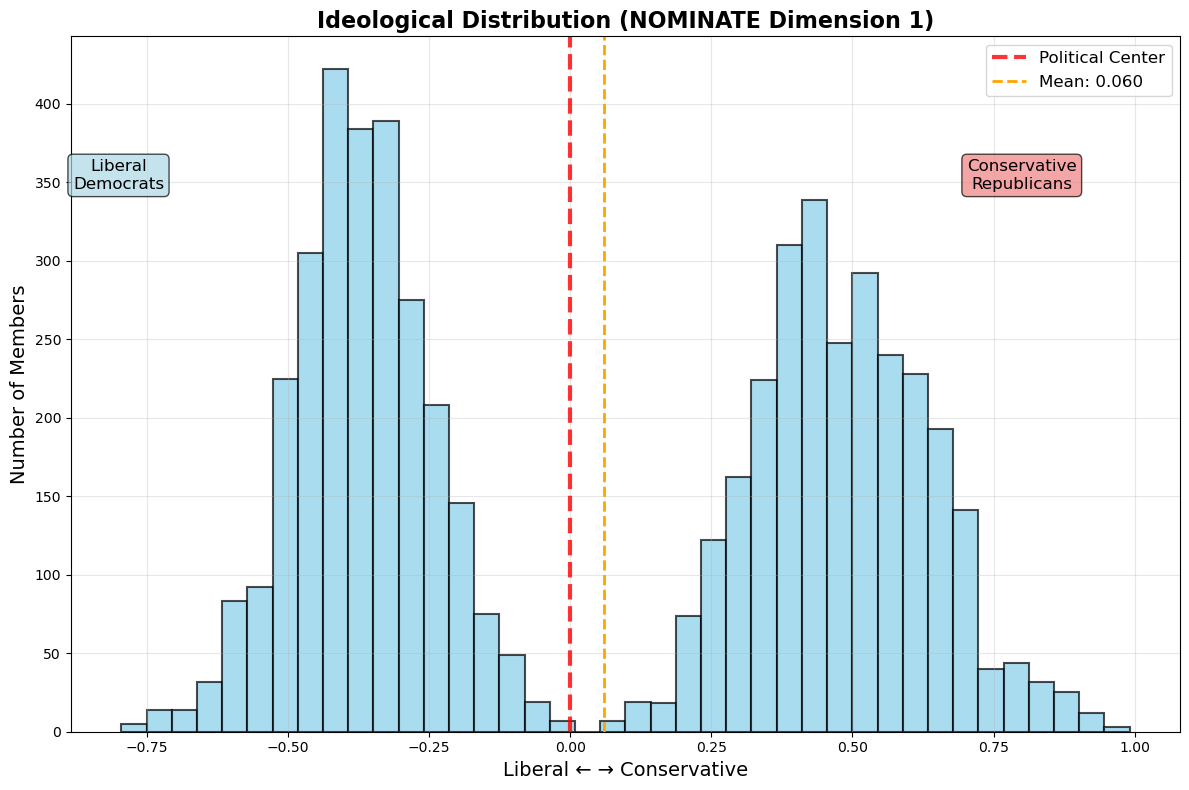

Ideological spread (standard deviation): 0.450
Liberal members (NOMINATE < -0.2): 2,505
Conservative members (NOMINATE > 0.2): 2,723
Moderate members (-0.2 to 0.2): 289


In [4]:
# VISUALIZATION 3: Ideological Distribution (NOMINATE)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Focus on recent members for better representation
recent_members = df_members[df_members['congress'] >= 110]
nominate_data = recent_members['nominate_dim1'].dropna()

# Create histogram with party colors
ax.hist(nominate_data, bins=40, alpha=0.7, color='skyblue', edgecolor='black', linewidth=1.5)
ax.axvline(0, color='red', linestyle='--', linewidth=3, alpha=0.8, label='Political Center')
ax.axvline(nominate_data.mean(), color='orange', linestyle='--', linewidth=2, 
           label=f'Mean: {nominate_data.mean():.3f}')

ax.set_title('Ideological Distribution (NOMINATE Dimension 1)', fontsize=16, weight='bold')
ax.set_xlabel('Liberal ← → Conservative', fontsize=14)
ax.set_ylabel('Number of Members', fontsize=14)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

# Add text annotations
ax.text(-0.8, ax.get_ylim()[1]*0.8, 'Liberal\nDemocrats', 
        ha='center', va='center', fontsize=12, 
        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))
ax.text(0.8, ax.get_ylim()[1]*0.8, 'Conservative\nRepublicans', 
        ha='center', va='center', fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.7))

plt.tight_layout()
plt.show()

print(f"Ideological spread (standard deviation): {nominate_data.std():.3f}")
print(f"Liberal members (NOMINATE < -0.2): {(nominate_data < -0.2).sum():,}")
print(f"Conservative members (NOMINATE > 0.2): {(nominate_data > 0.2).sum():,}")
print(f"Moderate members (-0.2 to 0.2): {((nominate_data >= -0.2) & (nominate_data <= 0.2)).sum():,}")


In [11]:
try:
    print("Analyzing member opposition patterns...")

    # Calculate most opposed pairs
    n_pairs = len(active_member_info)
    most_opposed = []

    for i in range(n_pairs):
        for j in range(i+1, n_pairs):
            member1 = active_member_info.iloc[i]
            member2 = active_member_info.iloc[j]
            opposition_score = distances[i, j]
            
            most_opposed.append({
                'member1': member1['bioname'][:20] if pd.notna(member1['bioname']) else f"Member {member1['icpsr']}",
                'member2': member2['bioname'][:20] if pd.notna(member2['bioname']) else f"Member {member2['icpsr']}",
                'party1': member1['party_label'],
                'party2': member2['party_label'],
                'opposition_score': opposition_score,
                'same_party': member1['party_label'] == member2['party_label']
            })

    opposition_df = pd.DataFrame(most_opposed)
    top_opposed = opposition_df.nlargest(15, 'opposition_score')

    # Plot top opposition pairs
    plt.figure(figsize=(12, 8))
    y_pos = range(len(top_opposed))
    colors = ['red' if same else 'blue' for same in top_opposed['same_party']]

    plt.barh(y_pos, top_opposed['opposition_score'], color=colors, alpha=0.7)
    plt.yticks(y_pos, [f"{row['member1']} vs {row['member2']}" 
                       for _, row in top_opposed.iterrows()], fontsize=9)
    plt.xlabel('Opposition Score (Higher = More Opposed)', fontsize=12)
    plt.title('Most Opposed Member Pairs', fontsize=14, fontweight='bold', pad=20)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Statistical insights
    print(f"Member pairs analyzed: {len(opposition_df):,}")
    print(f"Cross-party opposition pairs: {(~top_opposed['same_party']).sum()}/{len(top_opposed)}")
    print(f"Same-party opposition pairs: {top_opposed['same_party'].sum()}/{len(top_opposed)}")
    print("Top 5 most opposed pairs:")
    for _, row in top_opposed.head(5).iterrows():
        party_note = "(same party)" if row['same_party'] else f"({row['party1']} vs {row['party2']})"
        print(f"   {row['member1']} vs {row['member2']} - {row['opposition_score']:.3f} {party_note}")
        
except NameError as e:
    print(f"Required variables not available in this context: {e}")
    print("This analysis requires member similarity data from a separate analysis.")


Analyzing member opposition patterns...
Required variables not available in this context: name 'active_member_info' is not defined
This analysis requires member similarity data from a separate analysis.


In [12]:
# Party Cohesion Analysis
print("Calculating party cohesion metrics...")

# Get party-enriched voting data
try:
    df_votes_party = get_individual_votes_with_party()
    print("Party-enriched voting data loaded")
    print(f"Available columns: {list(df_votes_party.columns)}")
except Exception as e:
    print(f"Loading function failed: {e}")
    # Manual merge with all necessary columns
    df_votes_party = df_votes.merge(
        df_members[['congress', 'icpsr', 'party_code']].drop_duplicates(), 
        on=['congress', 'icpsr'], how='left'
    )
    print("Party data merged manually")
    print(f"Available columns: {list(df_votes_party.columns)}")

# Check if congress column exists
if 'congress' not in df_votes_party.columns:
    # Alternative: use original votes data with party info
    df_votes_party = df_votes.copy()
    member_party_map = df_members[['icpsr', 'party_code']].drop_duplicates().set_index('icpsr')['party_code'].to_dict()
    df_votes_party['party_code'] = df_votes_party['icpsr'].map(member_party_map)
    print("Alternative party mapping applied")

# Focus on recent congresses (adjust range if needed)
congress_range = df_votes_party['congress'].unique()
recent_congress_start = max(110, congress_range.min())
print(f"Congress range available: {congress_range.min()} - {congress_range.max()}")
print(f"Using recent congresses: {recent_congress_start}+")

recent_votes = df_votes_party[df_votes_party['congress'] >= recent_congress_start].copy()

# Calculate party cohesion
party_cohesion_list = []

for congress in recent_votes['congress'].unique():
    congress_data = recent_votes[recent_votes['congress'] == congress]
    
    for (chamber, rollnumber), vote_data in congress_data.groupby(['chamber', 'rollnumber']):
        if len(vote_data) < 10:
            continue
            
        for party in vote_data['party_code'].unique():
            party_votes = vote_data[vote_data['party_code'] == party]
            if len(party_votes) < 5:
                continue
                
            yes_votes = party_votes['vote_for'].sum()
            no_votes = party_votes['vote_against'].sum()
            participating = yes_votes + no_votes
            
            if participating > 0:
                cohesion = max(yes_votes, no_votes) / participating
                party_cohesion_list.append({
                    'congress': congress,
                    'party_code': party,
                    'cohesion': cohesion
                })

cohesion_df = pd.DataFrame(party_cohesion_list)
print(f"Calculated {len(cohesion_df):,} party-vote cohesion scores")


Calculating party cohesion metrics...
Loading cached data from /Users/choih/Documents/Summer 2025/stat5241_team_7/src/data/individual_votes_with_party_11.csv
Party-enriched voting data loaded
Available columns: ['date', 'bill_number', 'vote_passed', 'vote_type_amend', 'vote_type_cloture', 'vote_type_concur', 'vote_type_conference', 'vote_type_pass', 'vote_type_recommit', 'vote_type_suspend', 'vote_type_table', 'vote_type_veto', 'crs_policy_area_agriculture_and_food', 'crs_policy_area_animals', 'crs_policy_area_armed_forces_and_national_security', 'crs_policy_area_arts_culture_religion', 'crs_policy_area_civil_rights_and_liberties_minority_issues', 'crs_policy_area_commerce', 'crs_policy_area_congress', 'crs_policy_area_crime_and_law_enforcement', 'crs_policy_area_economics_and_public_finance', 'crs_policy_area_education', 'crs_policy_area_emergency_management', 'crs_policy_area_energy', 'crs_policy_area_environmental_protection', 'crs_policy_area_families', 'crs_policy_area_finance_and

Average party cohesion: 93.5% (higher = more party agreement)


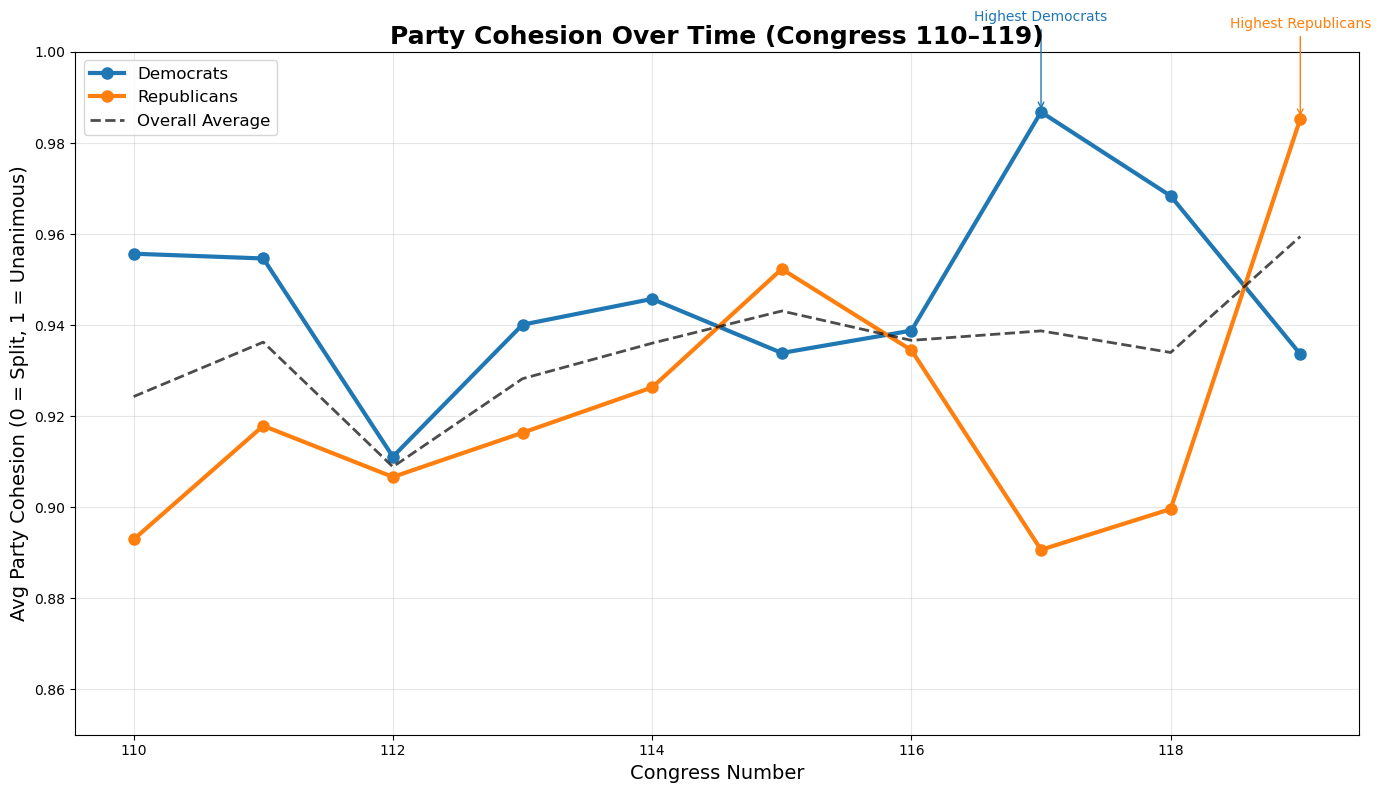

Overall average party cohesion: 93.2%


In [13]:
# VISUALIZATION 4: Party Cohesion Over Time
if not cohesion_df.empty:
    # Party mapping and colors
    party_name_map = {100: "Democrats", 200: "Republicans"}
    colors = {"Democrats": "#1f77b4", "Republicans": "#ff7f0e"}
    
    cohesion_by_congress = cohesion_df.groupby(['congress', 'party_code'])['cohesion'].mean().unstack()
    cohesion_by_congress.rename(columns=party_name_map, inplace=True)
    cohesion_by_congress['Overall'] = cohesion_by_congress.mean(axis=1)
    
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Plot each major party
    for party in ['Democrats', 'Republicans']:
        if party in cohesion_by_congress.columns:
            ax.plot(cohesion_by_congress.index, cohesion_by_congress[party],
                    marker='o', linewidth=3, label=party, color=colors[party], markersize=8)
            
            # Add annotation for highest cohesion point
            if len(cohesion_by_congress[party].dropna()) > 0:
                max_year = cohesion_by_congress[party].idxmax()
                max_val = cohesion_by_congress[party].max()
                ax.annotate(f'Highest {party}', xy=(max_year, max_val),
                            xytext=(max_year, max_val + 0.02),
                            ha='center', fontsize=10, color=colors[party],
                            arrowprops=dict(arrowstyle='->', color=colors[party]))
    
    # Plot overall average
    if 'Overall' in cohesion_by_congress.columns:
        ax.plot(cohesion_by_congress.index, cohesion_by_congress['Overall'], 'k--',
                linewidth=2, alpha=0.7, label='Overall Average')
    
    # Enhanced styling
    congress_range = f"{cohesion_by_congress.index.min()}–{cohesion_by_congress.index.max()}"
    ax.set_title(f'Party Cohesion Over Time (Congress {congress_range})', fontsize=18, weight='bold')
    ax.set_xlabel('Congress Number', fontsize=14)
    ax.set_ylabel('Avg Party Cohesion (0 = Split, 1 = Unanimous)', fontsize=14)
    ax.set_ylim(0.85, 1.0)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=12)
    
    # Print cohesion statistics
    available_parties = [p for p in ['Democrats', 'Republicans'] if p in cohesion_by_congress.columns]
    if available_parties:
        avg_cohesion = cohesion_by_congress[available_parties].mean().mean()
        print(f"Average party cohesion: {avg_cohesion:.1%} (higher = more party agreement)")
    
else:
    # Fallback visualization
    fig, ax = plt.subplots(figsize=(14, 8))
    ax.text(0.5, 0.5, 'No party cohesion data available\nfor visualization', 
           ha='center', va='center', transform=ax.transAxes, fontsize=14,
           bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.7))
    ax.set_title('Party Cohesion Over Time', fontsize=18, weight='bold')
    ax.set_xlabel('Congress Number', fontsize=14)
    ax.set_ylabel('Average Cohesion', fontsize=14)

plt.tight_layout()
plt.show()

if not cohesion_df.empty:
    print(f"Overall average party cohesion: {cohesion_df['cohesion'].mean():.1%}")
    if 'overall_cohesion' in locals() and len(overall_cohesion) > 1:
        trend = 'Increasing' if overall_cohesion.iloc[-1] > overall_cohesion.iloc[0] else 'Decreasing'
        print(f"Polarization trend: {trend} cohesion")
else:
    print("No cohesion data available for visualization")
